###1. Выберите алгоритм обучения с учителем с большим числом гиперпараметров.
    возьмем дерево решений
###2. Выберите набор данных и целевую функцию оценки алгоритма.
    f1 score

In [1]:
import pandas as pd
import numpy as np
import os
import re
from scipy.io import arff
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from IPython.display import clear_output
import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
pd.options.mode.chained_assignment = None 
os.environ['PYTHONWARNINGS']='ignore::FutureWarning'

In [ ]:
!unzip OpenML.zip

In [3]:
data_list = os.listdir('/content/data')
data_list = [int(item.replace('.arff','')) for item in data_list]
data_list.sort()
data_list.pop(1)

2

In [4]:
data = arff.loadarff('/content/data/'+ str(data_list[0])+'.arff')
dff1 = pd.DataFrame(data[0])
cols = [col for col in dff1.columns if dff1[col].dtype=="O"]
dff1[cols]=dff1[cols].apply(lambda x: x.str.decode('utf8'))
dff1.head()

,family,product-type,steel,carbon,hardness,temper_rolling,condition,formability,strength,non-ageing,...,'s','p',shape,thick,width,len,oil,bore,packing,class
0,?,C,A,8.0,0.0,?,S,?,0.0,?,...,?,?,COIL,0.700,610.0,0.0,?,0,?,3
1,?,C,R,0.0,0.0,?,S,2,0.0,?,...,?,?,COIL,3.200,610.0,0.0,?,0,?,3
2,?,C,R,0.0,0.0,?,S,2,0.0,?,...,?,?,SHEET,0.700,1300.0,762.0,?,0,?,3
3,?,C,A,0.0,60.0,T,?,?,0.0,?,...,?,?,COIL,2.801,385.1,0.0,?,0,?,3
4,?,C,A,0.0,60.0,T,?,?,0.0,?,...,?,?,SHEET,0.801,255.0,269.0,?,0,?,3


In [5]:
def preprocess_data(df1,data1):
  # определяем чиловые и категориальные признаки
  num = []
  cat = []
  lst = str(data1[1:]).replace('\t','').split('\n')[1:-1]
  for i in range(len(lst)):
    lst[i] = re.sub(r'\'s','',lst[i])
    if re.findall(r'numeric|nominal|data',lst[i])[0] =='numeric':
      num.append(df1.columns[i])
    else:
      cat.append(df1.columns[i])

  # меняем'?' на np.nan и обрабатываем nan
  df1 = df1.replace('?', np.nan)
  for column in df1.columns:
    if df1[column].isnull().sum()>=len(df1)/2:
      del df1[column]
      continue
    if df1[column].nunique() == 1:
      del df1[column]
      continue
    # замена на наиболее встречающееся для категориальных и среднее(.mean()/медиану(.median()) для числовых 
    if column in cat:
      df1[column] = df1[column].fillna(df1[column].mode().values[0])
    else: df1[column] = df1[column].fillna(df1[column].mean())
    # удаление строк с пропусками  
    # df = df.dropna()

  cat_cols = []
  num_cols = []
  for item in df1.columns:
    if item in cat:
      cat_cols.append(item)
    elif item in num:
      num_cols.append(item)
  return df1, num_cols, cat_cols

In [6]:
def preprocess_for_train(df, cat_cols, num_cols):
  le = preprocessing.LabelEncoder()
  y = le.fit_transform(df.iloc[:,-1])
  # нормализация численных столбцов
  if num_cols !=[]:
    df_num = (df[num_cols]-df[num_cols].mean())/(df[num_cols].std())
  # ohe для категориальных
  if cat_cols[:-1]!=[]:
    df_cat = pd.get_dummies(df[cat_cols[:-1]])
  if num_cols !=[] and cat_cols[:-1]!=[]:
    X = pd.concat([df_num,df_cat],axis =1)
  elif num_cols !=[]:
    X = df_num
  else:
    X = df_cat
  return X, y

In [7]:
dfn, num, cat = preprocess_data(dff1, data)
real_X,real_y = preprocess_for_train(dfn, cat, num)

In [8]:
if dfn.iloc[:,-1].nunique() != 2:
  flag = 'micro'
else:
  flag = 'binary'

###3. Реализуйте алгоритм байесовской оптимизации.
функция улучшения: Ожидаемое улучшение

суррогатная функция: Гауссовский процесс

In [9]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [10]:
# суррогатная функция
def gauss(surrogate_df):
  m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
  # m52 = DotProduct() + WhiteKernel()
  gpr = GaussianProcessRegressor(kernel=m52, alpha=0.2**2)
  # gpr = GaussianProcessRegressor( alpha=0.2**2)
  gpr.fit(surrogate_df.iloc[:,:-1].to_numpy(), surrogate_df.iloc[:,-1].to_numpy())
  return gpr

# функция улучшения Acquisition Functions
def ei(surrogate_model, p_df):
  ei_res = []
  idx = []
  mean_y = surrogate_model.predict(p_df.to_numpy())

  for i in range(20):
    numb = random.randint(20, len(p_df)-1)
    idx.append(numb)
    x_new = p_df.iloc[numb,:]
    mean_y_new, sigma_y_new = surrogate_model.predict(np.array([x_new]), return_std=True)
    sigma_y_new = sigma_y_new.reshape(-1,1)
    if sigma_y_new == 0.0:
      ei_res.append(0.0)
    max_mean_y = np.max(mean_y)
    z = (mean_y_new - max_mean_y) / sigma_y_new
    ei_res.append((mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z))
  max_idx = ei_res.index(max(ei_res))
  return idx[max_idx]

In [11]:
# датасет параметров
def make_dfs():
  p_df = pd.DataFrame(columns = [ 'criterion', 'max_depth','min_samples_split', 'min_samples_leaf'])
  criterions_map = {'gini':0, 'entropy':1}
  criterions = ['gini', 'entropy']
  max_depths = [2,3,4,6,8,10,12,18,20,22,30]
  min_samples_splits = [2,3,4,5,6,7,8,10]
  min_samples_leafs = [2,3,4,5,6,7,8,10]
  for cri in criterions:
    for depths in max_depths:
      for spl in min_samples_splits:
        for leafs in min_samples_leafs:
          row = [criterions_map[cri], depths, spl, leafs]
          p_df.loc[len(p_df.index)] = row 
  # датасет для суррогатной модели
  s_df = pd.DataFrame(columns = [ 'criterion', 'max_depth','min_samples_split', 'min_samples_leaf', 'f1'])
  return p_df, s_df

In [12]:
def real_model(X_df, y_df, params,flag):
  param= params[:-1].copy()
  criterion = {0: 'gini', 1: 'entropy'}
  X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, train_size=0.75, random_state=42)
  param['criterion'] = criterion[param['criterion']]
  model = DecisionTreeClassifier()
  model.set_params(**param)
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  return f1_score(y_test, preds, average=flag)

def update_sur(surrogate_df, real_data, flag):
  surrogate_df = surrogate_df.fillna('')
  idx = surrogate_df[surrogate_df['f1']==''].index.values
  for i in idx:
    surrogate_df['f1'][i]= real_model(real_data[0], real_data[1], sur_df.iloc[i,:], flag)
  return surrogate_df


In [29]:
n = 150
params_df, sur_df = make_dfs()
all_res = []
step_params = []
# инициализация 
for j in range(20):
      number = random.randint(0, len(params_df)-1)
      sur_df = sur_df.append(params_df.iloc[number], ignore_index = True)
# обучить на реальных данных реальную модель для каждого выбранного набора параметров и посчитать f1-score, обновляем данные sur_df
sur_df = update_sur(sur_df,[real_X,real_y],flag)  
# обучить на полученных данных суррогатную модель
sur_model = gauss(sur_df)
for i in range(n):
  # посчитать значение функции улучшения для 20 рандомных наборов параметров и выбрать наилучший
  max_idx = ei(sur_model, params_df)
  # вычисляем реальное значение иобновляем набор данных
  step_params.append(params_df.iloc[max_idx])
  sur_df = sur_df.append(params_df.iloc[max_idx], ignore_index = True)
  sur_df = update_sur(sur_df,[real_X,real_y],flag)  
  # обновление суррогатной функции
  sur_model = gauss(sur_df)
  res = sur_model.predict(params_df.to_numpy())
  all_res.append(res)
  print('итерация №', i, 'гиперпараметры выбранные на данном шаге:', params_df.iloc[max_idx].values)

итерация № 0 гиперпараметры выбранные на данном шаге: [1 30 8 6]
итерация № 1 гиперпараметры выбранные на данном шаге: [0 30 5 8]
итерация № 2 гиперпараметры выбранные на данном шаге: [0 22 10 10]
итерация № 3 гиперпараметры выбранные на данном шаге: [0 30 3 6]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 4 гиперпараметры выбранные на данном шаге: [1 30 3 5]
итерация № 5 гиперпараметры выбранные на данном шаге: [0 30 4 3]
итерация № 6 гиперпараметры выбранные на данном шаге: [1 30 5 8]
итерация № 7 гиперпараметры выбранные на данном шаге: [1 22 8 10]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 8 гиперпараметры выбранные на данном шаге: [0 30 10 8]
итерация № 9 гиперпараметры выбранные на данном шаге: [1 30 10 7]
итерация № 10 гиперпараметры выбранные на данном шаге: [1 30 4 10]
итерация № 11 гиперпараметры выбранные на данном шаге: [1 22 10 10]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 12 гиперпараметры выбранные на данном шаге: [0 30 4 10]
итерация № 13 гиперпараметры выбранные на данном шаге: [1 30 4 10]
итерация № 14 гиперпараметры выбранные на данном шаге: [0 30 4 10]
итерация № 15 гиперпараметры выбранные на данном шаге: [1 22 2 10]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 16 гиперпараметры выбранные на данном шаге: [1 30 3 3]
итерация № 17 гиперпараметры выбранные на данном шаге: [0 30 3 2]
итерация № 18 гиперпараметры выбранные на данном шаге: [1 30 7 5]
итерация № 19 гиперпараметры выбранные на данном шаге: [1 30 10 7]
итерация № 20 гиперпараметры выбранные на данном шаге: [1 30 6 3]
итерация № 21 гиперпараметры выбранные на данном шаге: [0 30 6 10]
итерация № 22 гиперпараметры выбранные на данном шаге: [1 30 5 4]
итерация № 23 гиперпараметры выбранные на данном шаге: [0 30 8 10]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:4

итерация № 24 гиперпараметры выбранные на данном шаге: [0 30 2 10]
итерация № 25 гиперпараметры выбранные на данном шаге: [1 30 5 8]
итерация № 26 гиперпараметры выбранные на данном шаге: [1 22 10 10]
итерация № 27 гиперпараметры выбранные на данном шаге: [0 22 6 3]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 28 гиперпараметры выбранные на данном шаге: [0 30 10 7]
итерация № 29 гиперпараметры выбранные на данном шаге: [1 30 2 8]
итерация № 30 гиперпараметры выбранные на данном шаге: [0 30 3 3]
итерация № 31 гиперпараметры выбранные на данном шаге: [0 30 3 7]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 32 гиперпараметры выбранные на данном шаге: [0 22 2 5]
итерация № 33 гиперпараметры выбранные на данном шаге: [0 30 2 3]
итерация № 34 гиперпараметры выбранные на данном шаге: [1 30 2 2]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 35 гиперпараметры выбранные на данном шаге: [1 30 2 2]
итерация № 36 гиперпараметры выбранные на данном шаге: [0 30 6 8]
итерация № 37 гиперпараметры выбранные на данном шаге: [0 30 2 2]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 38 гиперпараметры выбранные на данном шаге: [1 30 3 2]
итерация № 39 гиперпараметры выбранные на данном шаге: [1 30 2 2]
итерация № 40 гиперпараметры выбранные на данном шаге: [1 30 8 2]


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


итерация № 41 гиперпараметры выбранные на данном шаге: [0 30 2 8]
итерация № 42 гиперпараметры выбранные на данном шаге: [0 2 10 8]
итерация № 43 гиперпараметры выбранные на данном шаге: [0 30 6 3]
итерация № 44 гиперпараметры выбранные на данном шаге: [0 30 3 3]
итерация № 45 гиперпараметры выбранные на данном шаге: [0 22 10 3]
итерация № 46 гиперпараметры выбранные на данном шаге: [1 30 2 10]
итерация № 47 гиперпараметры выбранные на данном шаге: [0 30 4 10]
итерация № 48 гиперпараметры выбранные на данном шаге: [1 30 2 3]
итерация № 49 гиперпараметры выбранные на данном шаге: [1 30 6 10]
итерация № 50 гиперпараметры выбранные на данном шаге: [0 30 5 8]
итерация № 51 гиперпараметры выбранные на данном шаге: [0 22 10 5]
итерация № 52 гиперпараметры выбранные на данном шаге: [1 30 3 2]
итерация № 53 гиперпараметры выбранные на данном шаге: [1 30 7 7]
итерация № 54 гиперпараметры выбранные на данном шаге: [1 22 2 7]
итерация № 55 гиперпараметры выбранные на данном шаге: [1 30 6 2]
итера

In [14]:
len(params_df)

1408

###4. Сравните алгоритм байесовской оптимизации со случайным поиском.

In [15]:
def random_search(data, num_step, df_random):
    data['f1'] = np.nan
    for i in range (0, num_step):
        number = random.randint(0,len(data)-1)
        data['f1'][number] = real_model(real_X, real_y,data.iloc[number,:-1], flag)
        df_random = df_random.append(data.iloc[number], ignore_index = True )
    return df_random

In [16]:
#целевое значение параметров
target = params_df.copy()
target['f1'] = np.nan
for i in range(len(target)):
  target['f1'][i] = real_model(real_X, real_y,target.iloc[i,:-1], flag)
target[target['f1'] == target['f1'].max()]

,criterion,max_depth,min_samples_split,min_samples_leaf,f1
357,0,10,6,7,0.933333
406,0,12,4,8,0.933333
645,0,30,2,7,0.933333


In [30]:
# результат байесовской оптимизации
predict_df = params_df.copy()
predict_df['f1'] = res
predict_df.iloc[np.where(res == max(res))]

,criterion,max_depth,min_samples_split,min_samples_leaf,f1
1344,1,30,2,2,0.910897


In [35]:
# результат случайного поиска
df_random = pd.DataFrame(columns=['criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'f1'])
df_random = random_search(params_df, n, df_random)
df_random[df_random['f1'] == df_random['f1'].max()]

,criterion,max_depth,min_samples_split,min_samples_leaf,f1
45,1,18,2,3,0.928889
50,1,30,3,2,0.928889
83,1,30,3,2,0.928889
99,0,20,5,2,0.928889


In [31]:
# найдем целевое значение f1 score для гиперпараметров из результата байесовской оптимизации
target.iloc[np.where(res == max(res))]

,criterion,max_depth,min_samples_split,min_samples_leaf,f1
1344,1,30,2,2,0.924444


###5. Визуализируйте пространство протестированных значений гиперпараметров. Цветом обозначьте значение целевой функции на них.

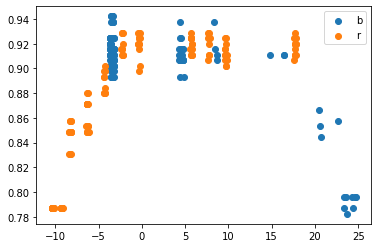

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
X_sur = sur_df.iloc[:,:-1]
y_sur = sur_df.iloc[:,-1]
X_rand = df_random.iloc[:,:-1]
y_rand = df_random.iloc[:,-1]
pca1 = PCA(n_components=1)
pca2 = PCA(n_components=1)
components1 = pca1.fit_transform(X_sur)
components2 = pca2.fit_transform(X_rand)
# tsne1 = TSNE(n_components=1)
# components1 = tsne.fit_transform(X_sur)
# tsne2 = TSNE(n_components=1)
# components2 = tsne.fit_transform(X_rand)
components_x1 = [item[0] for item in components1]
components_x2 = [item[0] for item in components2]
plt.scatter(components_x1,y_sur, label= 'b')
plt.scatter(components_x2,y_rand, label= 'r')
plt.legend()
plt.show()

###6. Визуализируйте значение целевой функции в зависимости от номера шага.

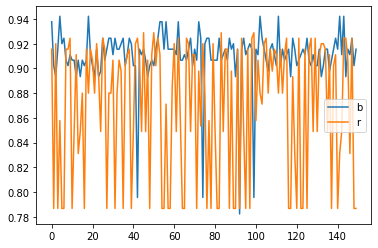

In [36]:
x = range(n)
y_b = [sur_df['f1'].iloc[20+i] for i in range(n)]
y_cum_b = sur_df['f1'].iloc[20:].cummax() 
# y_b = [target['f1'].iloc[step_params[i]].values[0] for i in range(n)]
# y_b = [max(all_res[i]) for i in range(n)]
y_r = [df_random['f1'][i] for i in range(n)]
y_cum_r = df_random['f1'].cummax() 
plt.plot(x,y_b, label= 'b')
plt.plot(x,y_r, label= 'r')
plt.legend()
plt.show()

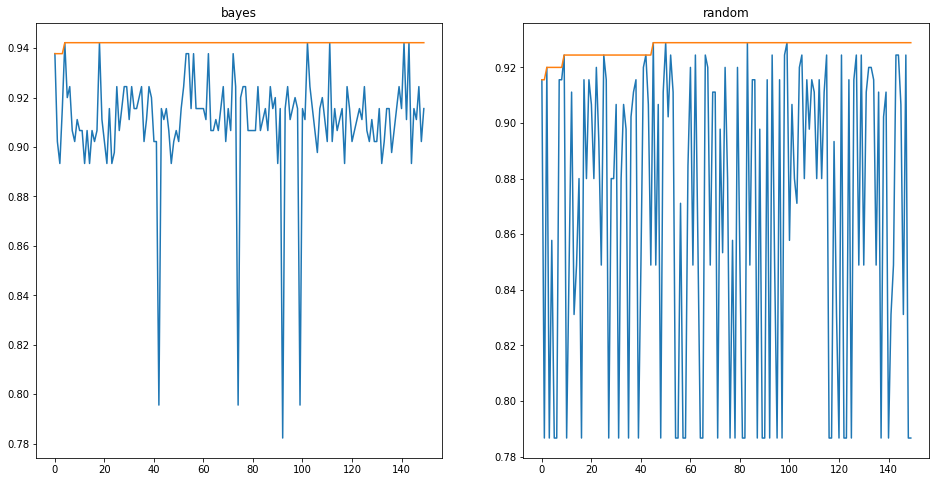

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,8))
ys = [y_b,y_r]
cum_ys = [y_cum_b, y_cum_r]
lbl = ['bayes', 'random']
i=0
for fig_x in ax.flatten():
    fig_x.plot(x,ys[i])
    fig_x.plot(x, cum_ys[i])
    fig_x.set_title(lbl[i])
    i+=1
fig.show()